In [ ]:
# Reference source outside the Learning from Data course: https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

# TO CHECK OUT TODO: https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,7)

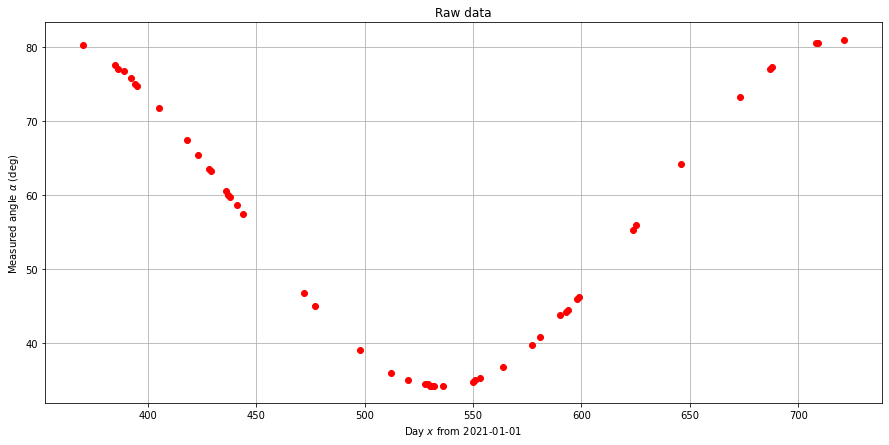

In [34]:
# DATA AND FITTED CURVE #
"""
    x:              days from 2021 
    measured_data:  max angle that day
    sigma:          standard deviation of measurement
    fitted_curve:   function of theta and x
"""
formatted_CSV_path = "Formatted CSV/SVM_PlotData_from_2022-01-01_to_2022-12-31.csv"
CSV = pd.read_csv(formatted_CSV_path, sep=',')
header = CSV.columns.values
day = np.array(CSV[header[3]])
measured_data = np.array(CSV[header[4]])
sigma = np.array(CSV[header[5]]) #the uncertainty in the measurements is +-0.25 deg # TODO: perhaps can do this better or more rigorously=

theta_max = np.array([90, 90, 2*np.pi/360, 2*np.pi]) #uniform prior max theta parameter value (from knowledge of physics of my problem)

plt.title("Raw data")
plt.plot(day, measured_data, 'ro')
plt.xlabel("Day $x$ from 2021-01-01")
plt.ylabel("Measured angle $\\alpha$ (deg)")
plt.grid()


def calculate_fitted_curve(theta, day):
    # g(x) = a + b*cos(c*x + d) as the function for the angle vs. day x
    # with theta = [a, b, c, d] we get
    a, b, c, d = theta
    return a + b*np.cos(c*day + d)

In [39]:
# FUNCTIONS #
def log_prior_flat(theta, theta_max):
    bool = 0
    for i in range(len(theta)):
        if np.abs(theta[i]) > theta_max[i]:
            bool = 1
 
    if bool == 0:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)


def log_likelihood(theta, day, measured_data, sigma):
    # Assumes same sigma for all measured datapoints:
    # measured_data_i = real_data_i + error_i, where error_i is normally distributed with sigma_i = sigma forall i 
    
    log_likelihood = 0
    for i in range(len(day)):
        fitted_curve_value = calculate_fitted_curve(theta, day[i])
        log_likelihood += -(1/2) * (fitted_curve_value - measured_data[i])**2 / sigma[i]**2 #log of likelihood is sum of chi^2-terms 
    
    return log_likelihood

#for scipy.optimize.minimize //2022-09-16
#minimize the negative posterior <==> maximize positive posterior
def log_posterior(theta, day, measured_data, sigma):
    return log_likelihood(theta, day, measured_data, sigma) + log_prior_flat(theta, theta_max)


In [41]:
# Preparations to run MCMC #
data = (day, measured_data, sigma)
initial_theta = np.array([0, 0, 0, 0]) #initial parameter guess

number_of_walkers = 500
number_of_iterations = 5
number_of_steps = 100
number_of_dimensions = len(initial_theta)
p0 = [np.array(initial_theta) + 1e-7 * np.random.randn(number_of_dimensions) for i in range(number_of_walkers)] #some probability of stepping from one gridpoint to another

def run_MCMC(p0, number_of_walkers, number_of_iterations, number_of_dimensions, number_of_steps, data, log_posterior):
    sampler = emcee.EnsembleSampler(number_of_walkers, number_of_dimensions, log_posterior, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, number_of_steps)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, number_of_iterations)

    return sampler, pos, prob, state

sampler, pos, prob, state = run_MCMC(p0, number_of_walkers, number_of_iterations, number_of_dimensions, number_of_steps, data, log_posterior)

Running burn-in...


ValueError: Probability function returned NaN

In [ ]:
samples = sampler.flatchain
sampled_parameter_values = samples[np.argmax(sampler.flatlnprobability)]
print(sampled_parameter_values)

labels = ['a','b','c','d']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.25, 0.5, 0.75])

NameError: name 'sampler' is not defined